In [1]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
from scipy.spatial import ConvexHull # for convex hull
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import matplotlib.pyplot as plt # for plotting
import numpy as np # for using arrays
import math # for mathematical operations
import pandas as pd # for using pandas dataframes
import seaborn as sns # for plotting in seaborn
from matplotlib.colors import LogNorm
from sklearn.model_selection import StratifiedKFold

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


# Read in data

In [3]:
########################
### READ IN METADATA ###
########################

mdata = pd.read_csv("./metadata.csv") # read in csv

mdata.head() # head data to check

,file,px_cm,include,base_x,base_y,tip_x,tip_y,done
0,LAMOEWC23246-1_1_13,116.0,Y,410.0,524.0,426.167,276.833,Y
1,LAMOEWC23246-1_10_13,116.0,N,386.0,450.0,392.833,351.500,Y
2,LAMOEWC23246-1_11_13,116.0,N,409.0,444.0,378.167,355.500,Y
3,LAMOEWC23246-1_12_13,116.0,N,406.0,445.0,399.500,352.833,Y
4,LAMOEWC23246-1_13_13,116.0,N,417.0,444.0,388.833,351.500,Y


In [4]:
#######################################
### MAKE A LIST OF IMAGE FILE NAMES ###
#######################################

data_dir = "./binary_leaves/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

#file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

['LAMOEWC23246-1_10_13.tif',
 'LAMOEWC23246-1_11_13.tif',
 'LAMOEWC23246-1_12_13.tif',
 'LAMOEWC23246-1_13_13.tif',
 'LAMOEWC23246-1_1_13.tif',
 'LAMOEWC23246-1_2_13.tif',
 'LAMOEWC23246-1_3_13.tif',
 'LAMOEWC23246-1_4_13.tif',
 'LAMOEWC23246-1_5_13.tif',
 'LAMOEWC23246-1_6_13.tif',
 'LAMOEWC23246-1_7_13.tif',
 'LAMOEWC23246-1_8_13.tif',
 'LAMOEWC23246-1_9_13.tif',
 'LAMOEWC23246-2_1_5.tif',
 'LAMOEWC23246-2_2_5.tif',
 'LAMOEWC23246-2_3_5.tif',
 'LAMOEWC23246-2_4_5.tif',
 'LAMOEWC23246-2_5_5.tif',
 'LAPALBS17132-1_10_28.tif',
 'LAPALBS17132-1_11_28.tif',
 'LAPALBS17132-1_12_28.tif',
 'LAPALBS17132-1_13_28.tif',
 'LAPALBS17132-1_14_28.tif',
 'LAPALBS17132-1_15_28.tif',
 'LAPALBS17132-1_16_28.tif',
 'LAPALBS17132-1_17_28.tif',
 'LAPALBS17132-1_18_28.tif',
 'LAPALBS17132-1_19_28.tif',
 'LAPALBS17132-1_1_28.tif',
 'LAPALBS17132-1_20_28.tif',
 'LAPALBS17132-1_21_28.tif',
 'LAPALBS17132-1_22_28.tif',
 'LAPALBS17132-1_23_28.tif',
 'LAPALBS17132-1_24_28.tif',
 'LAPALBS17132-1_25_28.tif',
 'LAP

# Process and landmark data

- Read in image in grayscale
- Select the contour of the largest object (the leaf)
- Interpolate with a high resolution of pseudo-landmarks
- Find the base and tip index point on the high resolution contour
- Reset the base index to zero
- Interpolate each side with desired number of equidistant pseudo-landmarks
- Rotate leaves and scale to centimeters
- Save pseudo-landmarks scaled to centimeters in an array

PARAMETERS AND INDEXING:
- `high_res_pts` is an arbitrarily high number of points to initially interpolate
- `res` is the desired number of points to interpolate on each side of the leaf
- The total number of pseudo-landmarks will be `2*res - 1`
- The base index will be `0`
- The tip index will be `res-1`
- The returned leaves in `cm_arr` are scaled in size to centimeters

First, find excluded and missing leaves where the metadata file name is not found in the binary files

In [5]:
exclude_leaves = [] # leaf names to exclude
exclude_inds = [] # indices of leaf names to exclude

missing_leaves = [] # metadata leaf name not in files
missing_inds = [] # indices of metadata leaf names not in files


# for each leaf . . .
for lf in range(len(mdata)):
    if mdata["include"][lf]=="N":
        exclude_leaves.append(mdata["file"][lf])
        exclude_inds.append(lf)

    elif mdata["file"][lf]+".tif" not in file_names:
        missing_leaves.append(mdata["file"][lf])
        missing_inds.append(lf)
        
print("There are", len(exclude_inds), "excluded leaves")
print("There are", len(missing_inds), "missing leaves")

# save the missing leaves
file_path = "missing_leaves.txt"
with open(file_path, 'w') as file:
    for item in missing_leaves:
        file.write(item + '\n')

There are 790 excluded leaves
There are 1213 missing leaves


Next, remove the indices of excluded or missing leaves before analysis

In [6]:
remove_inds = exclude_inds + missing_inds # create list of indices to remove from mdata

mdata = mdata.drop(remove_inds, axis=0)


mdata = mdata.reset_index() # Reset the index

In [7]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 10000

# the ultimate number of equidistant points on each side of the leaf
# (-1 for the tip)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
#################
res = 50 ########
#################
#################
#################

# an array to store pseudo-landmarks
cm_arr = np.zeros((len(mdata),(res*2)-1,2))

# for each leaf . . .
for lf in range(len(mdata)):

    ###############################
    ### READ IN GRAYSCALE IMAGE ###
    ###############################

    curr_image = mdata["file"][lf]+".tif" # select the current image

    if mdata["include"][lf]=="N":
        continue

    print(lf, curr_image) # print each leaf in case there are problems later

    # read in image
    # convert to grayscale
    # invert the binary
    img = cv2.bitwise_not(cv2.cvtColor(cv2.imread(data_dir + curr_image),cv2.COLOR_BGR2GRAY))

    # find contours of binary objects
    contours, hierarchy = cv2.findContours(img,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ##############################
    ### SELECT LARGEST CONTOUR ###
    ##############################

    # ideally there is only one leaf in the image
    # in the case there are smaller objects
    # this code selects the largest object (the leaf)
    # if there is one and only one object in the image
    # then the following code is not necessary

    x_conts = [] # list of lists of contour x vals
    y_conts = [] # list of lists of contour y vals
    areas_conts = [] # list of bounding box areas of contours
    for c in contours: # for each contour
        x_vals = [] # store x vals for current contour 
        y_vals = [] # store y vals for current contour
        for i in range(len(c)): # for each point in current contour
            x_vals.append(c[i][0][0]) # isolate x val
            y_vals.append(c[i][0][1]) # isolate y val
        area = (max(x_vals) - min(x_vals))*(max(y_vals) - min(y_vals)) # calculate bounding box area of contour
        x_conts.append(x_vals) # append the current contour x vals
        y_conts.append(y_vals) # append the current contour y vals
        areas_conts.append(area) # append the current contour bounding box areas

    area_inds = np.flip(np.argsort(areas_conts)) # get indices to sort contours by area
    sorted_x_conts = np.array(x_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, x vals
    sorted_y_conts = np.array(y_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, y vals

    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(np.array(sorted_x_conts[0], dtype=np.float32), 
                                           np.array(sorted_y_conts[0], dtype=np.float32), high_res_pts)

    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    # get the base and tip landmark point values
    base_pt = np.array((mdata["base_x"][lf], mdata["base_y"][lf]))
    tip_pt = np.array((mdata["tip_x"][lf], mdata["tip_y"][lf]))

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)

    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))

    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))

    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # calculate leaf area in pixels^2
    lf_area_px2 = poly_area(rot_pts[:,0], rot_pts[:,1])
    
    # get px_cm
    px_cm = mdata["px_cm"][lf]

    # scale leaf into cm
    cm_lf = rot_pts/(px_cm)
    
    # store the leaf scaled into cm into the cm_arr
    cm_arr[lf,:,:] = cm_lf


0 LAMOEWC23246-1_1_13.tif
1 LAMOEWC23246-1_2_13.tif
2 LAMOEWC23246-1_3_13.tif
3 LAMOEWC23246-1_6_13.tif
4 LAMOEWC23246-2_3_5.tif
5 LAMOEWC23246-2_5_5.tif
6 LAPALBS17132-1_1_28.tif
7 LAPALBS17132-1_2_28.tif
8 LAPALBS17132-1_3_28.tif
9 LAPALBS17132-1_4_28.tif
10 LAPPEAC21008-1_1_5.tif
11 LAPPEAC21008-1_2_5.tif
12 LAPPEAC21008-1_3_5.tif
13 LAPPEAC21008-1_4_5.tif
14 LAPPEAC21008-2_4_13.tif
15 LAPPEAC21008-2_6_13.tif
16 LAPPEAC21008-3_1_8.tif
17 LAPPEAC21008-3_4_8.tif
18 LAPPEAC21008-3_8_8.tif
19 LBATSPA21164-1_1_42.tif
20 LBATSPA21164-1_10_42.tif
21 LBATSPA21164-1_18_42.tif
22 LBATSPA21164-1_19_42.tif
23 LBATSPA21164-1_2_42.tif
24 LBATSPA21164-1_20_42.tif
25 LBATSPA21164-1_29_42.tif
26 LBATSPA21164-1_3_42.tif
27 LBATSPA21164-1_30_42.tif
28 LBATSPA21164-1_5_42.tif
29 LBATSPA21164-1_6_42.tif
30 LBREVAC21171-1_1_89.tif
31 LBREVAC21171-1_10_89.tif
32 LBREVAC21171-1_11_89.tif
33 LBREVAC21171-1_12_89.tif
34 LBREVAC21171-1_13_89.tif
35 LBREVAC21171-1_14_89.tif
36 LBREVAC21171-1_15_89.tif
37 LBREV

# Check by plotting random leaves

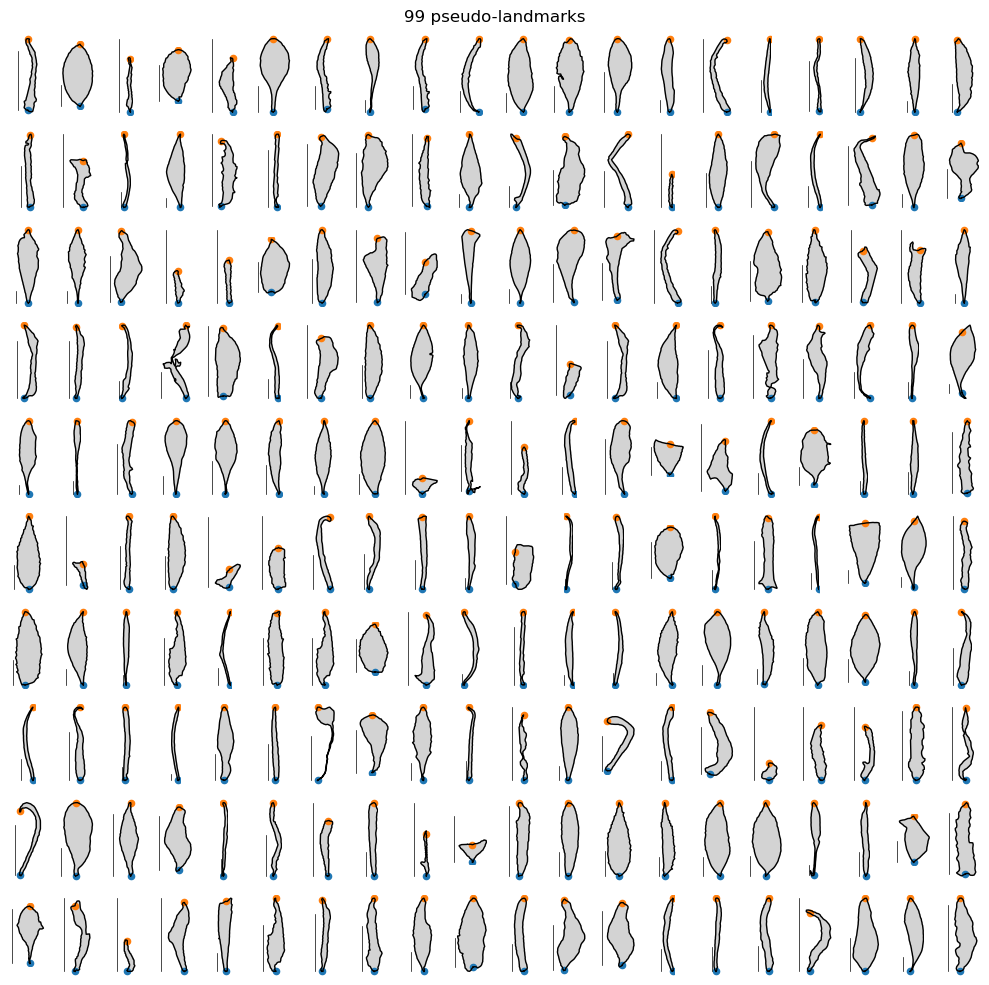

In [8]:
# Plot random leaves and check that it is working

plt.figure(figsize=(10,10)) # set figure size

rand_indices = np.random.randint(0,len(cm_arr),200) # generate random indices of leaves

plot_num = 1 # plot counter number

for i in rand_indices:
    
    plt.subplot(10,20,plot_num) # subplot number
    
    plt.plot(cm_arr[i,:,0], cm_arr[i,:,1], c="k", lw=1) # outline
    plt.fill(cm_arr[i,:,0], cm_arr[i,:,1], c="lightgray", lw=1) # fill
    
    plt.plot([min(cm_arr[i,:,0])-0.1,min(cm_arr[i,:,0])-0.1],
            [cm_arr[i,0,1], cm_arr[i,0,1]+1], c="k", lw=0.5) # cm scale
    
    #plt.scatter(cm_arr[i,:,0], cm_arr[i,:,1], c="k", s=0.1) # points
    plt.scatter(cm_arr[i,0,0], cm_arr[i,0,1], s=20) # base
    plt.scatter(cm_arr[i,res-1,0], cm_arr[i,res-1,1], s=20) # tip
    
    #plt.title(mdata["species"][i], fontsize=6)
    
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    plot_num += 1
    
plt.suptitle(str(res*2-1) + " pseudo-landmarks")
plt.tight_layout()

# Analyze leaf dimensions

Using placed pseudo-landmarks representing leaves that are rotated upwards and scaled in centimeters from `cm_arr`, calculate the following:

- `width`: difference in centimeters between minimum and maximum x values in an oriented leaf
- `length`: difference in centimeters between minimum and maximum y values in an oriented leaf
- `area`: area of the leaf in centimeters squared
- `solidity`: the ratio of area to convex hull area
- `asymmetry`: the Procrustes distance between the superimposed left and right sides of a leaf outline. Lower values are more symmetric. Higher values are more asymmetric.  

Data is stored in the `mdata` dataframe.

In [9]:
# lists to store variables
width_list = []
length_list = []
area_list = []
solidity_list = []
species_list = []
node_list = []
totalnode_list = []
#asymmetry_list = []

# for each leaf . . .
for lf in range(len(cm_arr)):
    
    # for calculating dimensions, we need non-scaled leaves in centimeters
    curr_lf = cm_arr[lf,:,:] # select current leaf

    # get species name
    species_list.append(mdata["file"][lf][:5])

    # get total node number
    totalnode_list.append( float(mdata["file"][lf][-1]) )

    # get the node number
    first_index = mdata["file"][lf].rfind("_")
    second_index = mdata["file"][lf].rfind("_", 0, first_index)
    node_list.append( float(mdata["file"][lf][second_index+1:first_index]) )
    
    ############################
    ### CALCULATE DIMENSIONS ###
    ############################
    
    width = np.max(curr_lf[:,0])-np.min(curr_lf[:,0]) # calculate width
    length = np.max(curr_lf[:,1])-np.min(curr_lf[:,1]) # calculate length
    area = poly_area(curr_lf[:,0],curr_lf[:,1]) # calcualte area
    
    ##########################
    ### CALCULATE SOLIDITY ###
    ##########################
    
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity = area / convex_area # calculate solidity
    
    ##########################
    ### CALCULATE SYMMETRY ###
    ##########################
    
    #left_side = curr_lf[:(res-1)+1,] # isolate left side of leaf
    #right_side = curr_lf[(res-1):,] # isolate right side of leaf
    #right_side = right_side[::-1] # reverse the right side to align indices with left

    # calculate procrustes distance between left and right side of leaf
    #s1, s2, distance = procrustes(left_side, right_side) 
    
    # store data in lists
    width_list.append(width)
    length_list.append(length)
    area_list.append(area)
    solidity_list.append(solidity)
    
    #asymmetry_list.append(distance)
    
# add data to the mdata dataframe
mdata["width"] = width_list
mdata["length"] = length_list
mdata["area"] = area_list
mdata["solidity"] = solidity_list
mdata["species"] = species_list
mdata["node"] = node_list
mdata["count"] = totalnode_list
mdata["rel_node"] = mdata["node"]/mdata["count"]
mdata["sqrt_area"] = np.sqrt(mdata["area"])
mdata["solidity8"] = (mdata["solidity"])**8
#mdata["asymmetry"] = asymmetry_list
    

# Pair plots by species

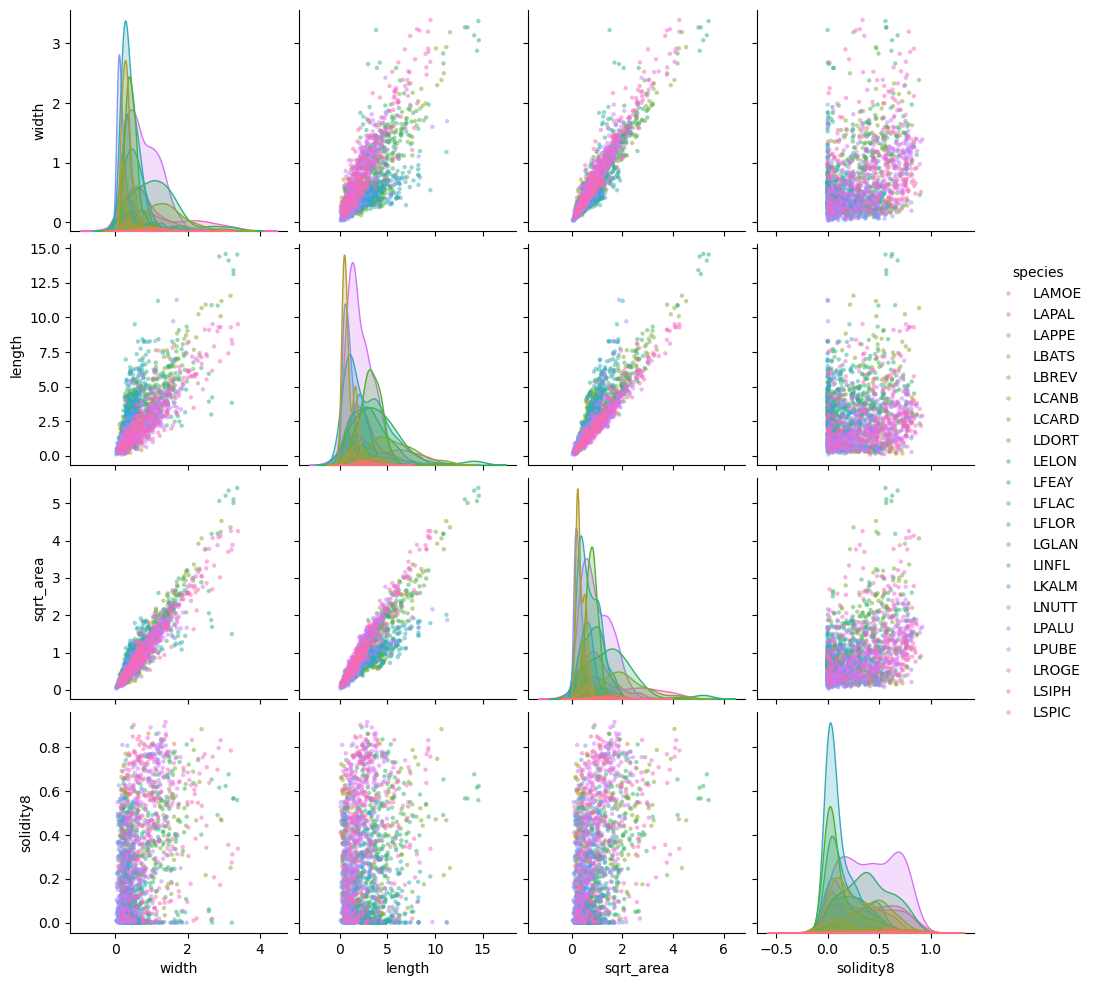

In [10]:
sns.pairplot(mdata,
             x_vars=["width", "length", "sqrt_area","solidity8"],
             y_vars=["width", "length", "sqrt_area","solidity8"],
             hue="species",
             plot_kws={"s": 10, "alpha":0.5, "lw":0}
            )


# Procrustes analysis

Perform a Procrustes analysis to translate, scale, and rotate leaf shapes

- Select number of pseudo-landmarks and dimensions
- Calculate the GPA mean leaf shape using the `gpa_mean` function
- Align all leaves to the GPA mean
- Store Procrustes super-imposed leaves in an array, `proc_arr`
- Calculate a PCA for all possible axes and their variance (the number of leaves)
- Calculate a PCA for just the axes needed for reconstruction of eigenleaves for morphospace (probably 2)

In [11]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(cm_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(cm_arr)) 

for i in range(len(cm_arr)):
    s1, s2, distance = procrustes(mean_shape, cm_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

In [12]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 198 # PC number = not number of leaves, but features
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


PC: var, overall 
PC1: 46.0%, 46.0%
PC2: 14.8%, 60.8%
PC3: 11.9%, 72.7%
PC4: 10.2%, 82.9%
PC5: 5.8%, 88.8%
PC6: 1.9%, 90.7%
PC7: 1.7%, 92.4%
PC8: 1.5%, 93.9%
PC9: 1.4%, 95.4%
PC10: 0.7%, 96.1%
PC11: 0.5%, 96.6%
PC12: 0.4%, 97.0%
PC13: 0.4%, 97.4%
PC14: 0.3%, 97.7%
PC15: 0.2%, 97.9%
PC16: 0.2%, 98.2%
PC17: 0.2%, 98.4%
PC18: 0.2%, 98.6%
PC19: 0.1%, 98.7%
PC20: 0.1%, 98.8%
PC21: 0.1%, 98.9%
PC22: 0.1%, 99.0%
PC23: 0.1%, 99.1%
PC24: 0.1%, 99.2%
PC25: 0.1%, 99.2%
PC26: 0.1%, 99.3%
PC27: 0.0%, 99.3%
PC28: 0.0%, 99.4%
PC29: 0.0%, 99.4%
PC30: 0.0%, 99.4%
PC31: 0.0%, 99.5%
PC32: 0.0%, 99.5%
PC33: 0.0%, 99.5%
PC34: 0.0%, 99.6%
PC35: 0.0%, 99.6%
PC36: 0.0%, 99.6%
PC37: 0.0%, 99.6%
PC38: 0.0%, 99.6%
PC39: 0.0%, 99.7%
PC40: 0.0%, 99.7%
PC41: 0.0%, 99.7%
PC42: 0.0%, 99.7%
PC43: 0.0%, 99.7%
PC44: 0.0%, 99.7%
PC45: 0.0%, 99.7%
PC46: 0.0%, 99.7%
PC47: 0.0%, 99.8%
PC48: 0.0%, 99.8%
PC49: 0.0%, 99.8%
PC50: 0.0%, 99.8%
PC51: 0.0%, 99.8%
PC52: 0.0%, 99.8%
PC53: 0.0%, 99.8%
PC54: 0.0%, 99.8%
PC55: 0.0%, 99.

In [13]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_comps = 5 # keep to 5 for now for reconstruction
#######

pca = PCA(n_components=PC_comps) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting
mdata["PC1"] = PCs[:,0]
mdata["PC2"] = PCs[:,1]
mdata["PC3"] = PCs[:,2]
mdata["PC4"] = PCs[:,3]
mdata["PC5"] = PCs[:,4]

PC: var, overall 
PC1: 46.0%, 46.0%
PC2: 14.8%, 60.8%
PC3: 11.9%, 72.7%
PC4: 10.2%, 82.9%
PC5: 5.8%, 88.8%


In [14]:
nstdev = 2 # set number of standard deviations
int = 20 # set interval number

## calculate PC vals for eigenkernels
PCval_arr = np.zeros((PC_comps, int, PC_comps)) # array to hold PC vals for eigenkernels
for i in range(PC_comps): # for each PC
    stdvals = np.linspace(-nstdev,+nstdev,int) # set standard deviation values to calculate eigenkernels
    for j in range(len(stdvals)): # for each stdval
        PCval_arr[i,j,i] =  (np.mean(PCs[:,i]))+np.std(PCs[:,i])*stdvals[j] # store PC vals

## calculate eigenleaf shapes
eigenlf = np.zeros((PC_comps, int, 2*res-1, 2))
for k in range(PC_comps):
    for l in range(int):
        # calculate the inverse eigenkernels
        inv_lf = pca.inverse_transform( PCval_arr[k,l,:] )
        inv_x = inv_lf[0:(2*res-1)*2:2] # select just inverse x vals
        inv_y = inv_lf[1:(2*res-1)*2:2] # select just inverse y vals
        eigenlf[k,l,:,:] = np.column_stack((inv_x, inv_y))

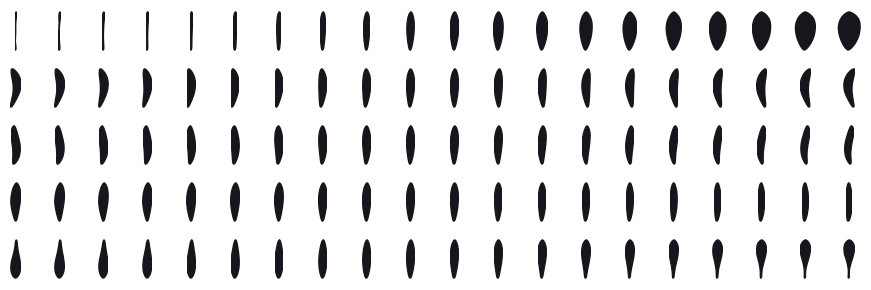

In [15]:
counter = 1
plt.figure(figsize=(9,3))

for m in range(PC_comps):
    for n in range(int):
        plt.subplot(PC_comps,int,counter)
        plt.fill(eigenlf[m,n,:,0], eigenlf[m,n,:,1], c="#16161d")
        plt.gca().set_aspect("equal")
        counter+=1
        plt.axis("off")
plt.tight_layout()

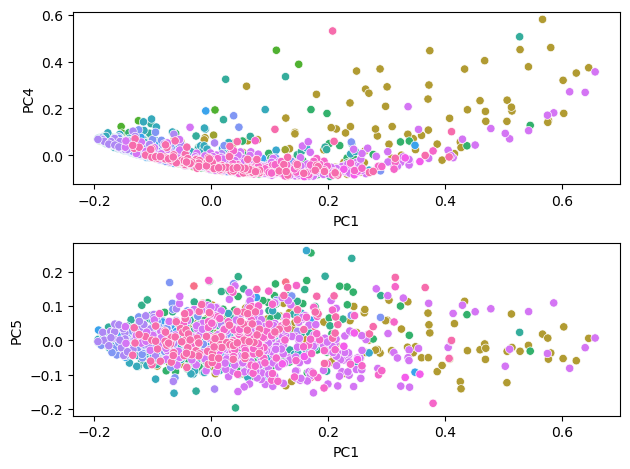

In [16]:
plt.subplot(2,1,1)
sns.scatterplot(mdata, x="PC1", y="PC4", hue="species", legend=False)

plt.subplot(2,1,2)
sns.scatterplot(mdata, x="PC1", y="PC5", hue="species", legend=False)

plt.tight_layout()

<Axes: xlabel='PC5', ylabel='Count'>

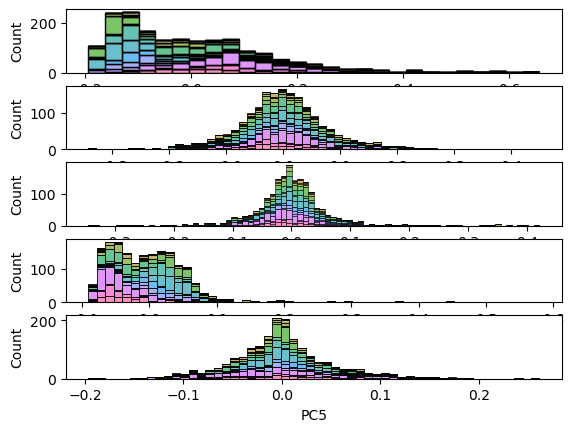

In [17]:
plt.subplot(5,1,1)
sns.histplot(mdata, x="PC1",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,2)
sns.histplot(mdata, x="PC2",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,3)
sns.histplot(mdata, x="PC3",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,4)
sns.histplot(mdata, x="PC4",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,5)
sns.histplot(mdata, x="PC5",hue="species", multiple="stack", legend=False)

Text(95.72222222222221, 0.5, 'Actual class')

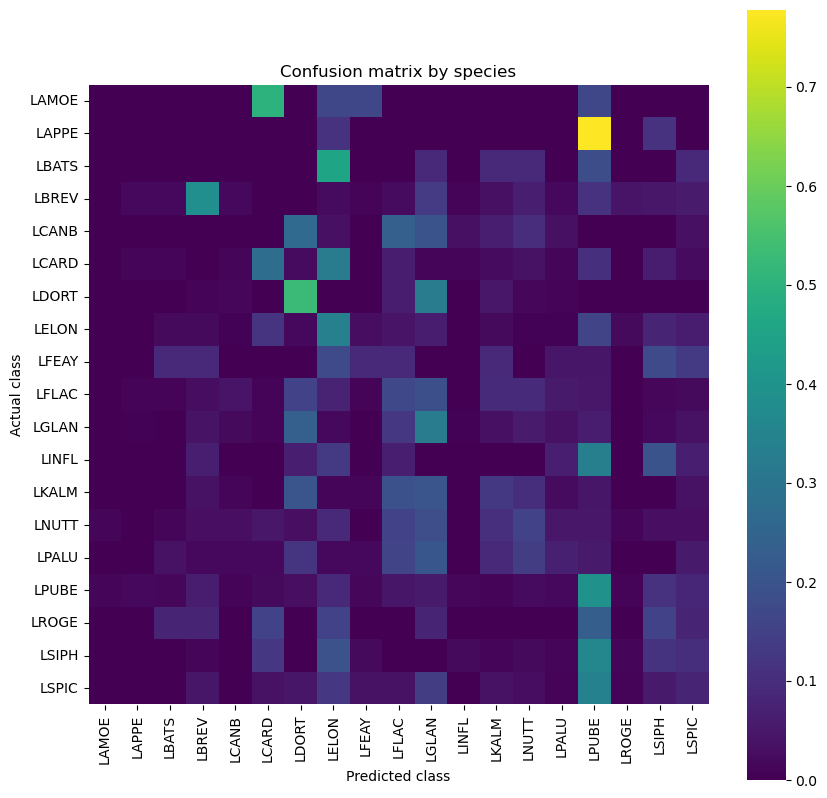

In [68]:
# get value counts of species
mdata["species"].value_counts()

# create a df for LDA by species
species_df = pd.DataFrame(data=flat_arr[:,:])

# List of factor levels to remove
# remove 5 or lower samples, for K fold stratified sampling of 5
levels_to_remove = ['LAPAL', 'LFLOR']

# list of indices to remove
indices_to_remove = mdata[mdata['species'].isin(levels_to_remove)].index.tolist()

# remove indices from procrustes coordinates
# create input and output variables
X = species_df.iloc[:,0:((res*2)-1)*2]
X = X.drop(indices_to_remove).reset_index(drop=True)
y = mdata["species"].drop(indices_to_remove).reset_index(drop=True)

# fit the LDA model
species_model = LinearDiscriminantAnalysis()

# create a StratifiedKFold object with k=5
skf = StratifiedKFold(n_splits=5)

# initialize an empty confusion matrix
cm = np.zeros( ( len(np.unique(y)), len(np.unique(y))  ))

# perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the LDA model on the training data
    species_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = species_model.predict(X_test)

    # Update the confusion matrix
    cm += confusion_matrix(y_test, y_pred)

row_sums = cm.sum(axis=1, keepdims=True)
cm = cm / row_sums

classes = np.sort(y.unique())

# Confusion matrix

plt.figure(figsize=(10,10))

sns.heatmap(cm, 
            #annot=False, 
            #annot_kws={"fontsize":8}, 
            #fmt="{0:f}", 
            cmap="viridis", 
            square=True, 
            cbar=True,
            xticklabels=classes,
            yticklabels=classes,
            #norm=LogNorm()
           )
plt.title("Confusion matrix by species")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")

Text(95.72222222222221, 0.5, 'Actual class')

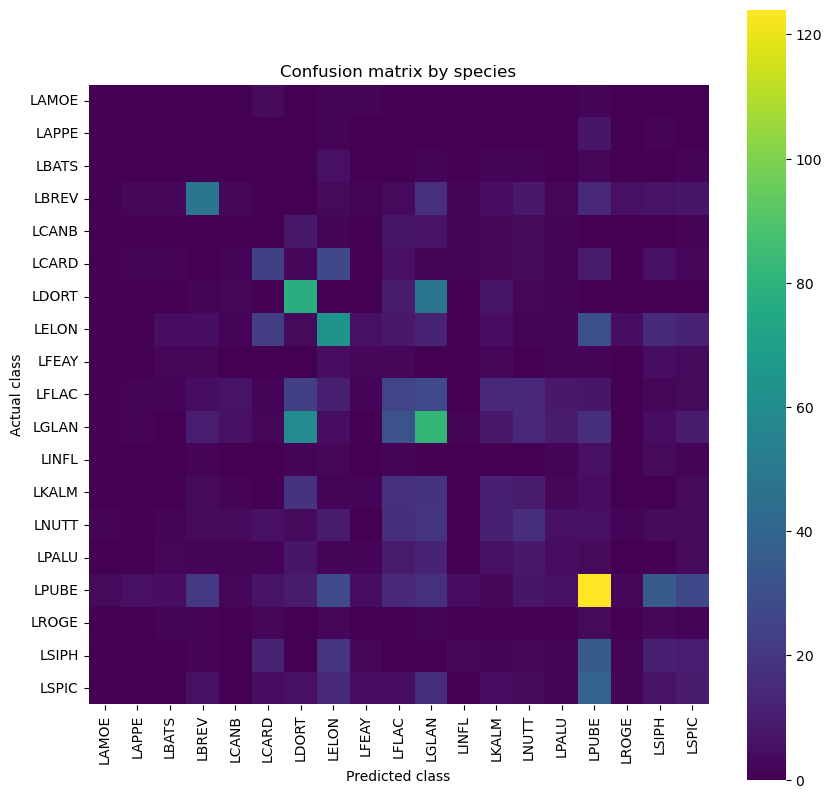

In [70]:
# get value counts of species
mdata["species"].value_counts()

# create a df for LDA by species
species_df = pd.DataFrame(data=flat_arr[:,:])

# List of factor levels to remove
# remove 5 or lower samples, for K fold stratified sampling of 5
levels_to_remove = ['LAPAL', 'LFLOR']

# list of indices to remove
indices_to_remove = mdata[mdata['species'].isin(levels_to_remove)].index.tolist()

# remove indices from procrustes coordinates
# create input and output variables
X = species_df.iloc[:,0:((res*2)-1)*2]
X = X.drop(indices_to_remove).reset_index(drop=True)
y = mdata["species"].drop(indices_to_remove).reset_index(drop=True)

# fit the LDA model
species_model = LinearDiscriminantAnalysis()

# create a StratifiedKFold object with k=5
skf = StratifiedKFold(n_splits=5)

# initialize an empty confusion matrix
cm = np.zeros( ( len(np.unique(y)), len(np.unique(y))  ))

# perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the LDA model on the training data
    species_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = species_model.predict(X_test)

    # Update the confusion matrix
    cm += confusion_matrix(y_test, y_pred)


classes = np.sort(y.unique())

# Confusion matrix

plt.figure(figsize=(10,10))

sns.heatmap(cm, 
            #annot=False, 
            #annot_kws={"fontsize":8}, 
            #fmt="{0:f}", 
            cmap="viridis", 
            square=True, 
            cbar=True,
            xticklabels=classes,
            yticklabels=classes,
            #norm=LogNorm()
           )
plt.title("Confusion matrix by species")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")

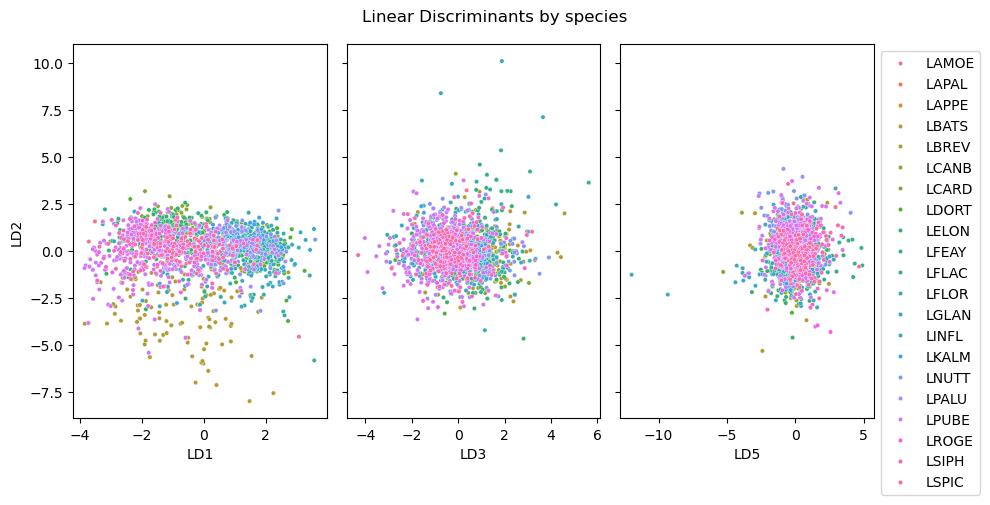

In [69]:
# Plot of linear discriminant scores by genotype

data_plot = species_model.fit(X, y).transform(X)
species_plot_df = pd.DataFrame(data=data_plot[:,:])
species_plot_df["species"] = mdata["species"]

species_plot_df = species_plot_df.rename(columns={0:'LD1', 1:'LD2', 2:"LD3", 3:"LD4", 4:"LD5", 5:"LD6"})

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(10,5))

sns.scatterplot(data=species_plot_df, x="LD1", y="LD2", hue="species", s=10, ax=ax1)
ax1.get_legend().remove()
sns.scatterplot(data=species_plot_df, x="LD3", y="LD4", hue="species", s=10, ax=ax2)
ax2.get_legend().remove()
sns.scatterplot(data=species_plot_df, x="LD5", y="LD6", hue="species", s=10, ax=ax3)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.suptitle("Linear Discriminants by species")

plt.tight_layout()
